In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any
from bbtoolkit.structures.synapses import TensorGroup, DirectedTensor, dict2directed_tensor
from bbtoolkit.math import pol2cart
from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.preprocessing.environment import Environment
from bbtoolkit.preprocessing.neural_generators import MTLGenerator, TCGenerator


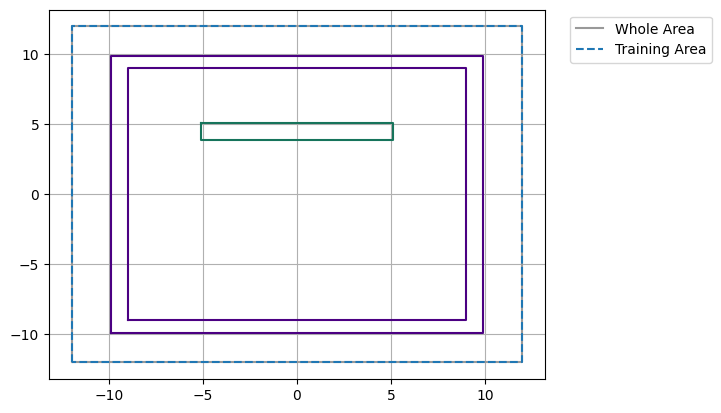

In [134]:
from bbtoolkit.preprocessing.environment.builders import EnvironmentBuilder

def env2builder(environment: Environment) -> EnvironmentBuilder:
    xy_min = np.min(environment.room.boundary.xy)
    xy_max = np.max(environment.room.boundary.xy)
    xy_train_min = tuple(np.min(environment.visible_area.boundary.xy, 1))
    xy_train_max = tuple(np.max(environment.visible_area.boundary.xy, 1))
    res = environment.params.res
    builder = EnvironmentBuilder(xy_min, xy_max, xy_train_min, xy_train_max, res)

    for wall in environment.walls:
        builder.add_wall(wall.polygon)
    for obj in environment.objects:
        builder.add_object(obj.polygon)

    return builder

builder = env2builder(Environment.load('../data/envs/main_environment.pkl'))
fig = builder.plot()

In [135]:
from abc import ABC
from collections import OrderedDict
from dataclasses import dataclass
from typing import Callable
from shapely.geometry import Polygon

from typing import Literal
from bbtoolkit.data import Copyable
from bbtoolkit.math.geometry import create_cartesian_space, regroup_min_max
from bbtoolkit.preprocessing.environment.compilers import EnvironmentCompiler
from bbtoolkit.preprocessing.environment import Object, SpatialParameters
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlane
from bbtoolkit.structures.geometry import TexturedPolygon
from bbtoolkit.utils import remove_slice

@dataclass
class EnvironmentMetaData(Copyable):
    """
    A data class representing metadata of an environment.

    Attributes:
        type (Literal['object', 'wall']): The type of the entity.
        vp_slice (slice): The slice of the visible plane.
        vec_slice (slice): The slice of the boundaries in the array of all boundary points.
    """
    type: Literal['object', 'wall']
    vp_slice: slice
    vec_slice: slice


class BaseCompilerCallback:
    """
    A base class for creating callback hooks to respond to various events triggered by the
    DynamicEnvironmentCompiler during the compilation process.

    This class is intended to be subclassed to implement custom behavior for each event.

    Attributes:
        compiler (DynamicEnvironmentCompiler): A reference to the associated compiler instance.
                                               This should be set using the `set_compiler` method.
    """
    def __init__(self):
        self.compiler = None

    def set_compiler(self, compiler: 'DynamicEnvironmentCompiler'):
        """
        Sets the reference to the associated compiler instance.

        Args:
            compiler (DynamicEnvironmentCompiler): The compiler instance to associate with this callback.
        """
        self.compiler = compiler

    def on_change(self, i: int | slice, metadata: EnvironmentMetaData | list[EnvironmentMetaData]):
        """
        Called when an existing environment component is changed. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice of the components that have changed.
            metadata (EnvironmentMetaData | list[EnvironmentMetaData]): The metadata associated with
                the changed components.
        """
        ...

    def on_add(self, i: int | slice):
        """
        Called when a new environment component is added. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice where the new components are added.
        """
        ...

    def on_remove(self, i: int | slice, metadata: EnvironmentMetaData | list[EnvironmentMetaData]):
        """
        Called when an existing environment component is removed. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice of the components that are being removed.
            metadata (EnvironmentMetaData | list[EnvironmentMetaData]): The metadata associated with
                the removed components.
        """
        ...

    def on_add_object(self, i: int | slice):
        """
        Called when a new object is added to the environment. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice where the new objects are added.
        """
        ...

    def on_remove_object(self, i: int | slice, metadata: EnvironmentMetaData | list[EnvironmentMetaData]):
        """
        Called when an object is removed from the environment. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice of the objects that are being removed.
            metadata (EnvironmentMetaData | list[EnvironmentMetaData]): The metadata associated with
                the removed objects.
        """
        ...

    def on_add_wall(self, i: int | slice):
        """
        Called when a new wall is added to the environment. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice where the new walls are added.
        """
        ...

    def on_remove_wall(self, i: int | slice, metadata: EnvironmentMetaData | list[EnvironmentMetaData]):
        """
        Called when a wall is removed from the environment. Should be overridden in subclasses.

        Args:
            i (int | slice): The index or slice of the walls that are being removed.
            metadata (EnvironmentMetaData | list[EnvironmentMetaData]): The metadata associated with
                the removed walls.
        """
        ...


class DynamicEnvironmentCompiler(EnvironmentCompiler):
    """
    A class used to compile dynamic environments.

    Attributes:
        builder (EnvironmentBuilder): An instance of the EnvironmentBuilder class used to build the environment.
        visible_plane_compiler (Callable): A function used to compile the visible plane.

    Methods:
        get_n_vertices(polygon: Polygon) -> int: Returns the number of vertices in a given polygon.
        compile_visible_coordinates(objects: list[Polygon]): Compiles the coordinates of the visible space points.
        _get_entity_container(entity_type: str) -> list[TexturedPolygon]: Returns the list of entities of a given type.
        _add_entity(entities: list[TexturedPolygon], entities_type: Literal['object', 'wall']): Adds a list of entities of a given type to the environment.
        add_object(*objects: TexturedPolygon): Adds a list of objects to the environment.
        remove_entity(index: int, entity_type: Literal['object', 'wall']): Removes an entity of a given type from the environment.
        remove_object(index: int): Removes an object from the environment.
        add_wall(*walls: TexturedPolygon): Adds a list of walls to the environment.
        remove_wall(index: int): Removes a wall from the environment.
    """
    def __init__(
        self,
        builder: EnvironmentBuilder,
        visible_plane_compiler: Callable[
            [
                np.ndarray | list[np.ndarray],
                np.ndarray | list[np.ndarray],
                np.ndarray,
                list[np.ndarray]
            ],
            np.ndarray,
        ] = None,
        callbacks: BaseCompilerCallback | list[BaseCompilerCallback] = None
    ):
        """
        The constructor for DynamicEnvironmentCompiler class.

        Args:
            builder (EnvironmentBuilder): An instance of the EnvironmentBuilder class used to build the environment.
            visible_plane_compiler (Callable, optional): A function used to compile the visible plane. If None, LazyVisiblePlane is used. Defaults to None.
            callbacks (BaseCompilerCallback | list[BaseCompilerCallback], optional): A callback or a list of callbacks to be called on events. Defaults to None.
        """
        visible_plane_compiler = visible_plane_compiler if visible_plane_compiler is not None else LazyVisiblePlane
        super().__init__(builder, visible_plane_compiler)
        room_area = self.compile_room_area()
        visible_area = self.compile_visible_area()
        x_coords, y_coords = create_cartesian_space(
            *regroup_min_max(*visible_area.bounds),
            self.builder.res
        )
        self.space_points = self.compile_space_points(
            x_coords, y_coords
        )
        self.space_points_coordinates = np.array([
            [point.centroid.xy[0][0], point.centroid.xy[1][0]]
            for point in self.space_points
        ])

        visible_space_points_coordinates = self.compile_visible_coordinates(
            self.builder.walls + self.builder.objects
        )
        visible_objects = self.compile_objects(
            self.space_points,
            self.space_points_coordinates,
            visible_space_points_coordinates,
            self.builder.objects + self.builder.walls,
            self._visible_plane_compiler
        )
        self.visible_plane = visible_objects[0].visible_parts.visible_plane
        self.environment = Environment(
            room_area,
            visible_area,
            visible_objects[:len(self.builder.objects)],
            visible_objects[len(self.builder.objects):],
            SpatialParameters(
                self.builder.res,
                (x_coords, y_coords),
                visible_space_points_coordinates
            )
        )
        vertices = [
            self.get_n_vertices(obj.polygon) - 1 - 1*len(obj.polygon.interiors) # -1 because the last point is the same as the first one
            for obj in self.environment.objects + self.environment.walls
        ]
        cumulative_lengths = np.cumsum(vertices)
        vectors_slices = [slice(from_, to) for from_, to in zip([0] + list(cumulative_lengths[:-1]), cumulative_lengths)]

        self.objects_metadata = [
            EnvironmentMetaData('object', self.visible_plane.slices[i], vectors_slices[i])
            for i, _ in enumerate(self.builder.objects)
        ]
        self.objects_metadata += [ # objects go first in EnvironmentCompiler
            EnvironmentMetaData('wall', self.visible_plane.slices[i_], vectors_slices[i_])
            for i_ in range(
                len(self.builder.objects),
                len(self.builder.objects) + len(self.builder.walls)
            )
        ]
        self.callbacks = callbacks or []
        self.callbacks = self.callbacks if isinstance(self.callbacks, list) else [self.callbacks]

        for callback in self.callbacks:
            callback.set_compiler(self)

    @staticmethod
    def get_n_vertices(polygon: Polygon) -> int:
        """
        Static method to get the number of vertices in a given polygon.

        Args:
            polygon (Polygon): The polygon whose vertices are to be counted.

        Returns:
            int: The number of vertices in the polygon.
        """
        return len(polygon.exterior.coords) +\
            sum([
                len(interior.coords) for interior in polygon.interiors
            ] if len(polygon.interiors) > 0 else [0])

    def compile_visible_coordinates(
        self, objects: list[Polygon]
    ):
        """
        Method to compile the coordinates of the visible boundaries points.

        Args:
            objects (list[Polygon]): A list of polygons representing the objects in the environment.

        Returns:
            np.array: An array of coordinates of the visible space points.
        """
        visible_space_points = self.compile_room_points(
            self.space_points,
            objects
        )
        return np.array([
            [point.centroid.xy[0][0], point.centroid.xy[1][0]]
            for point in visible_space_points
        ])

    def _get_entity_container(self, entity_type: str) -> list[TexturedPolygon]:
        """
        Method to get the list of entities of a given type.

        Args:
            entity_type (str): The type of the entities to be returned. Can be 'object' or 'wall'.

        Returns:
            list[TexturedPolygon]: A list of entities of the given type.
        """
        if entity_type == 'object':
            return self.environment.objects
        elif entity_type == 'wall':
            return self.environment.walls

    def _add_entity(
        self,
        entities: list[TexturedPolygon],
        entities_type: Literal['object', 'wall']
    ):
        """
        Method to add a list of entities of a given type to the environment.

        Args:
            entities (list[TexturedPolygon]): A list of entities to be added to the environment.
            entities_type (Literal['object', 'wall']): The type of the entities to be added. Can be 'object' or 'wall'.
        """
        self.visible_plane.room_points_coordinates = self.compile_visible_coordinates(
            [obj.polygon for obj in self.environment.walls + self.environment.objects] + list(entities)
        )
        entities_corrected = self.align_objects(
            [self.space_points_coordinates for _ in range(len(entities))],
            entities
        )

        boundary_points = self.compile_boundary_points(self.space_points, entities_corrected)
        boundary_points_coordinates = [
            np.array([[point.centroid.xy[0][0], point.centroid.xy[1][0], 0] for point in boundary_point])
            for boundary_point in boundary_points
        ]
        # adding new boundary points to the existing ones
        self.visible_plane.boundary_points = np.concatenate([self.visible_plane.boundary_points, *boundary_points_coordinates])


        cumulative_lengths = np.cumsum([len(boundary) for boundary in boundary_points_coordinates])
        # adding new slices for the new objects
        self.visible_plane.slices += [
            slice(from_ + self.visible_plane.slices[-1].stop, to + self.visible_plane.slices[-1].stop)
            for from_, to in zip([0] + list(cumulative_lengths[:-1]), cumulative_lengths)
        ]

        # adding new starting points and directions
        starting_points, directions = self.compile_directions(entities_corrected)
        starting_points_concat, directions_concat = np.concatenate(starting_points), np.concatenate(directions)
        self.visible_plane.starting_points = np.concatenate([
            self.visible_plane.starting_points,
            np.concatenate( # add z coordinate with zeros to local starting points
                [
                    starting_points_concat,
                    np.zeros((*starting_points_concat.shape[:-1], 1))
                ],
                axis=-1
            )
        ])
        self.visible_plane.directions = np.concatenate([
            self.visible_plane.directions,
            np.concatenate( # add z coordinate with zeros to local starting points
                [
                    directions_concat,
                    np.zeros((*directions_concat.shape[:-1], 1))
                ],
                axis=-1
            )
        ])

        # cleaning cache
        self.visible_plane.cache_manager.cache = OrderedDict()
        n_existing_entities = len(self.environment.objects) + len(self.environment.walls)

        entities_container = self._get_entity_container(entities_type)

        for i, obj in enumerate(entities_corrected):
            entities_container.append(
                Object(
                    obj,
                    boundary_points_coordinates[i],
                    self.visible_plane[i + n_existing_entities],
                    starting_points[i],
                    directions[i]
                )
            )
            self.objects_metadata.append(
                EnvironmentMetaData(
                    entities_type,
                    self.visible_plane.slices[i + n_existing_entities],
                    slice(self.objects_metadata[-1].vec_slice.stop, self.objects_metadata[-1].vec_slice.stop + len(starting_points[i]))
                )
            )

        self.environment.params.coords = self.visible_plane.room_points_coordinates

        updated = slice(n_existing_entities, n_existing_entities + len(entities))

        for callback in self.callbacks:
            callback.on_change(updated, self.objects_metadata[updated])
            callback.on_add(updated)

            if entities_type == 'object':
                callback.on_add_object(updated)
            elif entities_type == 'wall':
                callback.on_add_wall(updated)

    def add_object(self, *objects: TexturedPolygon):
        """
        Method to add a list of objects to the environment.

        Args:
            objects (TexturedPolygon): The objects to be added to the environment.
        """
        self._add_entity(objects, 'object')

    def _remove_entity(self, index: int, entity_type: Literal['object', 'wall']):
        """
        Method to remove an entity of a given type from the environment.

        Args:
            index (int): The index of the entity to be removed.
            entity_type (Literal['object', 'wall']): The type of the entity to be removed. Can be 'object' or 'wall'.
        """
        entities_container = self._get_entity_container(entity_type)

        if index < 0:
            obj_index = len(entities_container) + index
        else:
            obj_index = index

        n_entities = -1
        for i, obj in enumerate(self.objects_metadata):
            if obj.type == entity_type:
                n_entities += 1

                if n_entities == obj_index:
                    abs_index = i

        self.visible_plane.room_points_coordinates = self.compile_visible_coordinates(
            [obj.polygon for obj in self.environment.walls + self.environment.objects if obj != entities_container[obj_index]]
        )
        # removing boundary points of the object
        self.visible_plane.boundary_points = np.concatenate([
            self.visible_plane.boundary_points[:self.objects_metadata[abs_index].vp_slice.start],
            self.visible_plane.boundary_points[self.objects_metadata[abs_index].vp_slice.stop:]
        ])
        # removing slices of the object
        self.visible_plane.slices = remove_slice(self.visible_plane.slices, abs_index)
        # removing starting points and directions of the object
        self.visible_plane.starting_points = np.concatenate([
            self.visible_plane.starting_points[:self.objects_metadata[abs_index].vec_slice.start],
            self.visible_plane.starting_points[self.objects_metadata[abs_index].vec_slice.stop:]
        ])
        self.visible_plane.directions = np.concatenate([
            self.visible_plane.directions[:self.objects_metadata[abs_index].vec_slice.start],
            self.visible_plane.directions[self.objects_metadata[abs_index].vec_slice.stop:]
        ])
        # cleaning cache
        self.visible_plane.cache_manager.cache = OrderedDict()
        # Remove object from the list
        if entity_type == 'object':
            self.environment.objects = self.environment.objects[:obj_index] + self.environment.objects[obj_index + 1:]
        elif entity_type == 'wall':
            self.environment.walls = self.environment.walls[:obj_index] + self.environment.walls[obj_index + 1:]

        for obj in self.environment.walls + self.environment.objects:
            if obj.visible_parts.object_index > abs_index:
                obj.visible_parts.object_index -= 1

        # Remove object from the metadata
        vp_slices = remove_slice([meta.vp_slice for meta in self.objects_metadata], abs_index)
        vec_slices = remove_slice([meta.vec_slice for meta in self.objects_metadata], abs_index)
        removed_meta = self.objects_metadata[abs_index].copy()
        self.objects_metadata = self.objects_metadata[:abs_index] + self.objects_metadata[abs_index + 1:]

        for meta, vp_slice, vec_slice in zip(self.objects_metadata, vp_slices, vec_slices):
            meta.vp_slice = vp_slice
            meta.vec_slice = vec_slice

        self.environment.params.coords = self.visible_plane.room_points_coordinates

        for callback in self.callbacks:
            callback.on_remove(abs_index, removed_meta)
            callback.on_change(abs_index, removed_meta)

            if entity_type == 'object':
                callback.on_remove_object(abs_index, removed_meta)
            elif entity_type == 'wall':
                callback.on_remove_wall(abs_index, removed_meta)

    def remove_object(self, index: int):
        """
        Method to remove an object from the environment.

        Args:
            index (int): The index of the object to be removed.
        """
        self._remove_entity(index, 'object')

    def add_wall(self, *walls: TexturedPolygon):
        """
        Method to add a list of walls to the environment.

        Args:
            walls (TexturedPolygon): The walls to be added to the environment.
        """
        self._add_entity(walls, 'wall')

    def remove_wall(self, index: int):
        """
        Method to remove a wall from the environment.

        Args:
            index (int): The index of the wall to be removed.
        """
        self._remove_entity(index, 'wall')

In [207]:
from functools import partial
from bbtoolkit.data import Cached
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlane


class LazyVisiblePlaneWithTransparancy(LazyVisiblePlane):
    """
    A class that extends LazyVisiblePlane to handle transparent objects in visible planes.

    Attributes:
        transparent_indices (list[int]): Indices of objects that are transparent.
        opaque_indices (list[int]): Indices of objects that are opaque.
        transparent_vectors_slices (list[slice]): Slices corresponding to vertexes of transparent objects (in starting_points and directions).
        opaque_vectors_slices (list[slice]): Slices corresponding to  vertexes of opaque objects (in starting_points and directions).

    Args:
        starting_points (list[np.ndarray]): List of starting points for the vectors.
        directions (list[np.ndarray]): List of direction vectors (vertex-wise differences).
        room_points_coordinates (np.ndarray): Array of room points coordinates.
        boundary_points_coordinates (list[np.ndarray]): List of objects boundary points coordinates.
        transparent (list[int], optional): List of indices that are transparent. Defaults to None.
        cache_manager (Cached, optional): Cache manager instance to use for caching. Defaults to None.
    """
    def __init__(
        self,
        starting_points: list[np.ndarray],
        directions: list[np.ndarray],
        room_points_coordinates: np.ndarray,
        boundary_points_coordinates: list[np.ndarray],
        transparent: list[int] = None,
        cache_manager: Cached = None
    ):
        """
        Initializes the LazyVisiblePlaneWithTransparancy instance.
        """
        super().__init__(
            starting_points,
            directions,
            room_points_coordinates,
            boundary_points_coordinates,
            cache_manager
        )
        self.transparent_indices = transparent if transparent is not None else []
        self.opaque_indices = np.setdiff1d(np.arange(len(starting_points)), transparent).tolist()
        slices = self.create_slices(directions)
        self.transparent_vectors_slices = slices[self.transparent_indices].tolist() if len(self.transparent_indices) != 0 else []
        self.opaque_vectors_slices = slices[self.opaque_indices].tolist() if len(self.opaque_indices) != 0 else []

    def track_new(self, vector_slice: slice, transparent: bool = False):
        """
        Tracks a new vector slice as either transparent or opaque.

        Args:
            vector_slice (slice): The slice of the vector to track.
            transparent (bool, optional): Flag indicating if the slice is transparent. Defaults to False.
        """
        container = self.transparent_indices if transparent else self.opaque_indices
        container.append(max(self.opaque_indices + self.transparent_indices) + 1)
        vectors_slices = self.transparent_vectors_slices if transparent else self.opaque_vectors_slices
        vectors_slices.append(vector_slice)

    def set_opaque(self, index: int):
        """
        Sets a previously transparent vector slice to opaque.

        Args:
            index (int): The index of the vector slice to set as opaque.
        """
        if index in self.opaque_indices:
            return
        num = self.transparent_indices.index(index)
        self.opaque_indices.append(self.transparent_indices.pop(num))
        self.opaque_vectors_slices.append(self.transparent_vectors_slices.pop(num))

    def set_transparent(self, index: int):
        """
        Sets a previously opaque vector slice to transparent.

        Args:
            index (int): The index of the vector slice to set as transparent.
        """
        if index in self.transparent_indices:
            return
        num = self.opaque_indices.index(index)
        self.transparent_indices.append(self.opaque_indices.pop(num))
        self.transparent_vectors_slices.append(self.opaque_vectors_slices.pop(num))

    def untrack(self, index: int):
        """
        Untracks a vector slice when corresponding object is removed.

        Args:
            index (int): The index of the vector slice to untrack.

        Raises:
            ValueError: If the index is not currently tracked.
        """
        all_indices = sorted(self.transparent_indices + self.opaque_indices)
        all_slices = sorted(self.transparent_vectors_slices + self.opaque_vectors_slices)

        if index not in all_indices:
            raise ValueError(f'Index {index} is not tracked')

        all_slices = remove_slice(all_slices, index)
        all_slices.insert(index, None)
        all_indices[index] = None

        #FIXME: DRY principle is violated here
        new_transparent_indices, new_transparent_slices = list(), list()
        for i in self.transparent_indices:
            if all_indices[i] is not None:
                new_transparent_indices.append(all_indices[i]) if \
                    all_indices[i] < index else new_transparent_indices.append(all_indices[i] - 1)
                new_transparent_slices.append(all_slices[i])

        self.transparent_indices = new_transparent_indices
        self.transparent_vectors_slices = new_transparent_slices

        new_opaque_indices, new_opaque_slices = list(), list()
        for i in self.opaque_indices:
            if all_indices[i] is not None:
                new_opaque_indices.append(all_indices[i]) if \
                    all_indices[i] < index else new_opaque_indices.append(all_indices[i] - 1)
                new_opaque_slices.append(all_slices[i])

        self.opaque_indices = new_opaque_indices
        self.opaque_vectors_slices = new_opaque_slices

    @staticmethod
    def create_slices(arraylist: list[np.ndarray]) -> list[slice]:
        """
        Creates a list of slices based on the lengths of arrays in the input list of arrays.

        Args:
            arraylist (list[np.ndarray]): List of arrays to create slices from.

        Returns:
            list[slice]: List of slices for the input arrays.
        """
        lengths = [len(arr) for arr in arraylist]
        slices = [slice(sum(lengths[:i]), sum(lengths[:i+1])) for i in range(len(lengths))]
        return np.array(slices)

    @staticmethod
    def slicemask(array: np.ndarray, slices: list[slice]) -> np.ndarray:
        """
        Creates a mask for an array based on the given slices.

        Args:
            array (np.ndarray): The array to mask.
            slices (list[slice]): The slices to use for masking.

        Returns:
            np.ndarray: The masked array.
        """
        mask = np.zeros(array.shape[0], dtype=bool)

        for sl in slices:
            mask[sl] = True

        return array[mask]

    def __call__(
        self,
        coords_x: float,
        coords_y: float
    ) -> list[np.ndarray]:
        """
        Makes the LazyVisiblePlaneWithTransparancy object callable and calculates visible points from the given coordinates.

        Args:
            coords_x (float): X coordinate.
            coords_y (float): Y coordinate.

        Returns:
            list[np.ndarray]: List of visible xy coordinates for each object.
        """
        @self.cache_manager
        def nested_call(
            coords_x: float,
            coords_y: float,
            starting_points, directions,
            boundary_points, slices
        ) -> list[np.ndarray]:
            return self._process_visible_coordinates(
                coords_x, coords_y,
                starting_points, directions,
                boundary_points, slices
            )

        hard_plane = nested_call(
            coords_x, coords_y,
            self.slicemask(self.starting_points, self.opaque_vectors_slices),
            self.slicemask(self.directions, self.opaque_vectors_slices),
            self.boundary_points,
            self.slices
        )
        hard_visible_boundary_points = np.concatenate([
            np.concatenate(hard_plane),
            np.zeros((len(self.boundary_points), 1))
        ], -1)
        for transparent_slice, transparent_index in zip(
            self.transparent_vectors_slices,
            self.transparent_indices
        ):
            hard_plane[transparent_index] = nested_call(
                coords_x, coords_y,
                self.starting_points[transparent_slice],
                self.directions[transparent_slice],
                hard_visible_boundary_points,
                [self.slices[transparent_index]]
            )[0]

        return hard_plane


class TransparentObjects(BaseCompilerCallback):
    """
    Callback class for handling transparent objects within a dynamic environment compilers.

    This class is designed to work with a compiler that has a visible plane capable of tracking transparency.
    It extends the BaseCompilerCallback with specific methods to handle the addition and removal of transparent objects.
    """
    def set_compiler(self, compiler: DynamicEnvironmentCompiler):
        """
        Sets the compiler instance for this callback and checks if the visible plane is of the correct type.

        Args:
            compiler (DynamicEnvironmentCompiler): The compiler instance to be used with this callback.

        Raises:
            TypeError: If the compiler's visible plane is not an instance of LazyVisiblePlaneWithTransparancy.
        """
        if not isinstance(compiler.visible_plane, LazyVisiblePlaneWithTransparancy):
            raise TypeError(f'Visible plane must be of type LazyVisiblePlaneWithTransparancy, got {type(compiler.visible_plane)} instead')
        super().set_compiler(compiler)

    def on_add_object(self, i: int | slice):
        """
        Tracks the addition of a transparent object or a range of transparent objects in the visible plane.

        Args:
            i (int | slice): The index or slice representing the object(s) to be tracked.
        """
        if isinstance(i, int):
            self.compiler.visible_plane.track_new(self.compiler.objects_metadata[i].vec_slice, True)
        elif isinstance(i, slice):
            for i_ in range(i.start, i.stop):
                self.compiler.visible_plane.track_new(self.compiler.objects_metadata[i_].vec_slice, True)

    def on_add_wall(self, i: int | slice):
        """
        Tracks the addition of a wall or a range of walls in the visible plane.

        Args:
            i (int | slice): The index or slice representing the wall(s) to be tracked.
        """
        if isinstance(i, int):
            self.compiler.visible_plane.track_new(self.compiler.objects_metadata[i].vec_slice, False)
        elif isinstance(i, slice):
            for i_ in range(i.start, i.stop):
                self.compiler.visible_plane.track_new(self.compiler.objects_metadata[i_].vec_slice, False)

    def on_remove(self, i: int | slice, metadata: EnvironmentMetaData | list[EnvironmentMetaData]):
        """
        Untracks objects that are removed from the visible plane.

        Args:
            i (int | slice): The index or slice representing the object(s) to be untracked.
            metadata (EnvironmentMetaData | list[EnvironmentMetaData]): The metadata of the object(s) being removed.
        """
        if isinstance(i, int):
            self.compiler.visible_plane.untrack(i)
        elif isinstance(i, slice):
            for i_ in range(i.start, i.stop):
                self.compiler.visible_plane.untrack(i_)




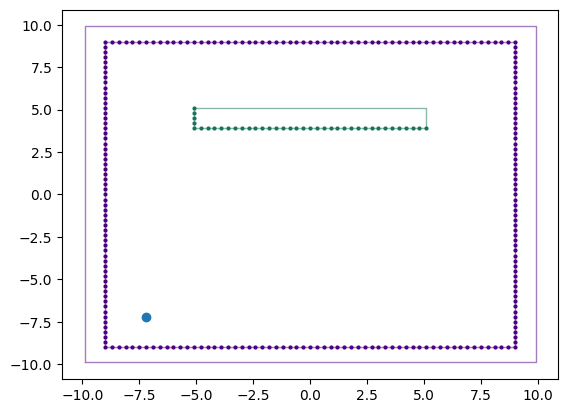

In [145]:
from bbtoolkit.preprocessing.environment.compilers import EnvironmentCompiler
from bbtoolkit.preprocessing.environment.viz import plot_polygon

compiler = EnvironmentCompiler(builder, partial(LazyVisiblePlaneWithTransparancy, transparent=[1,]))

lazy_env = compiler.compile()

fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(lazy_env.objects + lazy_env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    lazy_env.params.coords[position, 0],
    lazy_env.params.coords[position, 1],
    'o'
)

In [221]:
compiler = DynamicEnvironmentCompiler(builder, LazyVisiblePlaneWithTransparancy, callbacks=TransparentObjects())

In [222]:
from bbtoolkit.structures.geometry import Texture


compiler.add_object(
    TexturedPolygon(
        Polygon([
            (-5, -5),
            (-5, -7),
            (-6, -7),
            (-6, -5)
        ]),
        texture=Texture(
            1, '#f0a0a0', 'new_transparent_object'
        )
    ),
    TexturedPolygon(
        Polygon([
            (-1, -2),
            (0, -2),
            (0, -3),
            (-1, -3)
        ]),
        texture=Texture(
            1, '#f0a0a0', 'new_transparent_object'
        )
    )
)

compiler.add_wall(
    TexturedPolygon(
        Polygon([
            (5, -5),
            (5, -7),
            (6, -7),
            (6, -5)
        ]),
        texture=Texture(
            1, '#7a3e55', 'new_opaque_wall'
        )
    )
)

In [223]:
compiler.visible_plane.transparent_indices, compiler.visible_plane.opaque_indices

([2, 3], [0, 1, 4])

In [224]:
compiler.visible_plane.transparent_vectors_slices, compiler.visible_plane.opaque_vectors_slices

([slice(12, 16, None), slice(16, 20, None)],
 [slice(0, 8, None), slice(8, 12, None), slice(20, 24, None)])

In [228]:
compiler.remove_wall(0)

In [226]:
compiler.remove_object(-1)

In [215]:
compiler.visible_plane.transparent_indices, compiler.visible_plane.opaque_indices

([], [0, 1, 2])

In [216]:
compiler.visible_plane.transparent_vectors_slices, compiler.visible_plane.opaque_vectors_slices

([], [slice(0, 8, None), slice(8, 12, None), slice(12, 16, None)])

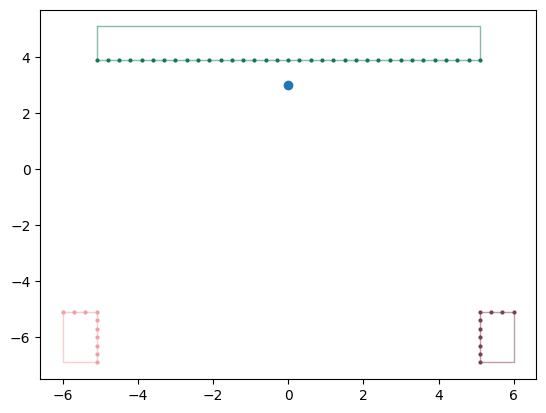

In [229]:
env = compiler.environment

fig, ax = plt.subplots()
position = 1500
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts(0, 3)[:, 0],
        obj.visible_parts(0, 3)[:, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    0, 3,
    'o'
)

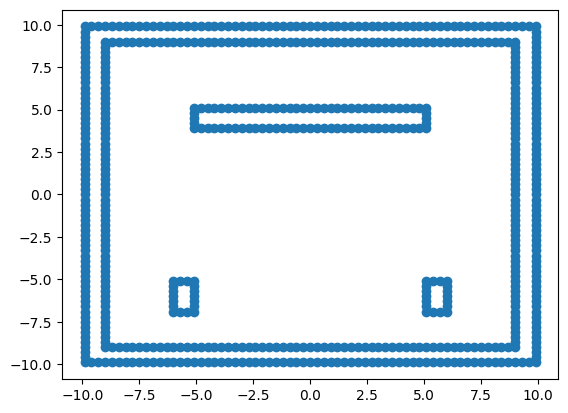

In [188]:
plt.plot(
    compiler.visible_plane.boundary_points[:, 0],
    compiler.visible_plane.boundary_points[:, 1],
    'o'
)

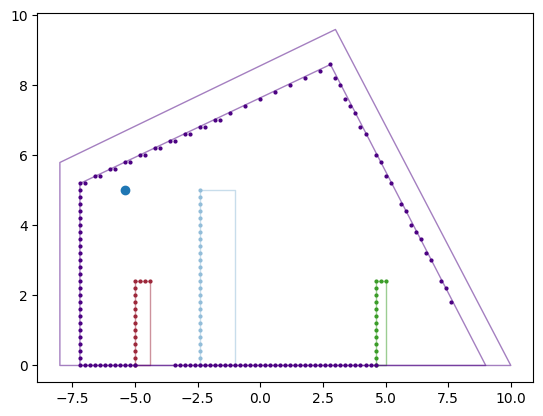

In [116]:

lazy_env = compiler.compile()

fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(lazy_env.objects + lazy_env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    lazy_env.params.coords[position, 0],
    lazy_env.params.coords[position, 1],
    'o'
)